I will first collect Google stock price data using the Yahoo Finance API:

In [93]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta

In [94]:
end_date = date.today().strftime('%Y-%m-%d')
start_date = (date.today() - timedelta(days=365)).strftime('%Y-%m-%d')

data = yf.download('GOOG',
                   start=start_date,
                   end=end_date,
                   progress=False)
data['Date'] = data.index
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
data.reset_index(drop=True, inplace=True)
display(data.head())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-25,119.429497,123.278000,118.769249,123.250000,123.250000,34522000
1,2022-04-26,122.750000,122.750000,119.161850,119.505997,119.505997,49394000
2,2022-04-27,114.373001,117.500000,113.124252,115.020500,115.020500,62238000
3,2022-04-28,117.114998,120.438499,115.143898,119.411499,119.411499,36790000
4,2022-04-29,117.578003,118.959999,114.694000,114.966499,114.966499,33694000


I only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [95]:
data = data[['Date', 'Close']]
display(data.head())

,Date,Close
0,2022-04-25,123.250000
1,2022-04-26,119.505997
2,2022-04-27,115.020500
3,2022-04-28,119.411499
4,2022-04-29,114.966499


Now let’s visualize the close prices of Google before moving forward:

In [96]:
import matplotlib.pyplot as plt

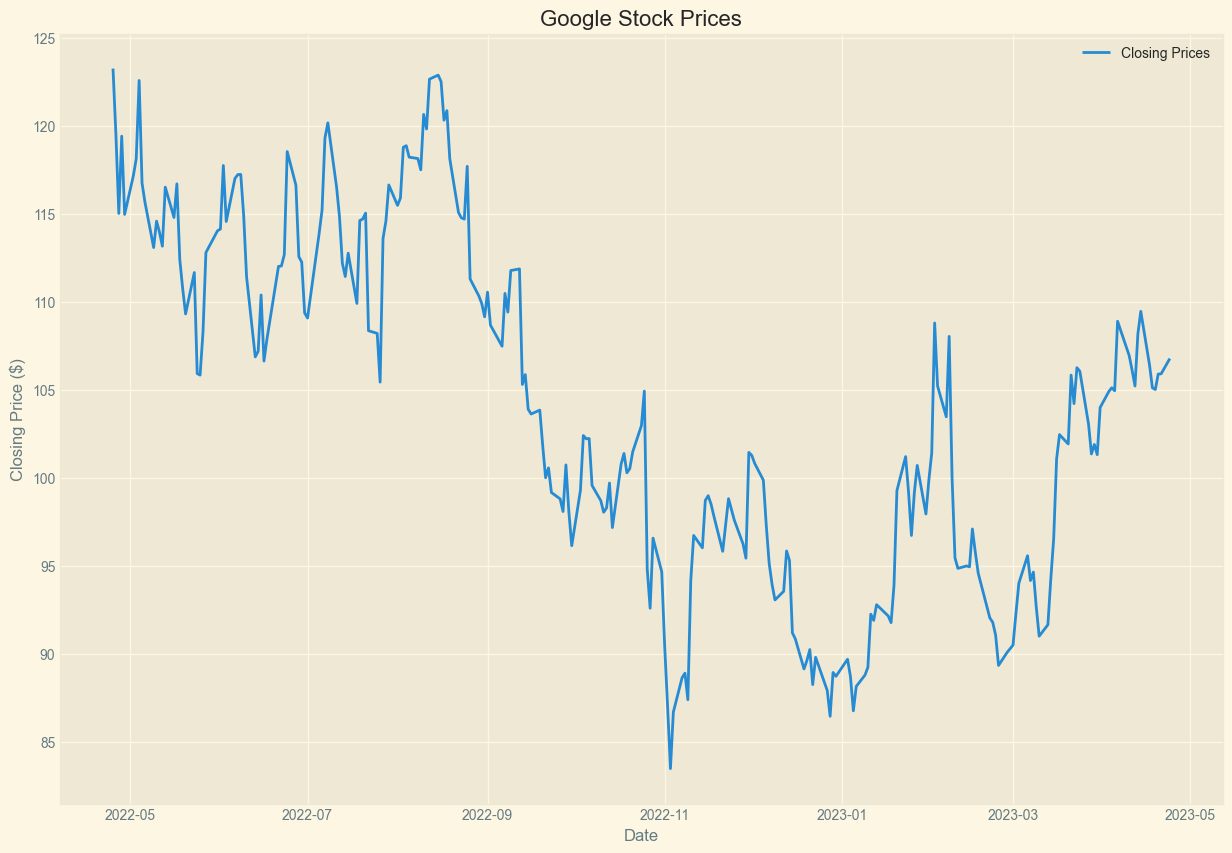

In [97]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15, 10))
plt.plot(data['Date'], data['Close'], label='Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.title('Google Stock Prices')
plt.legend()
plt.show()


Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the **seasonal decomposition** method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 640x480 with 0 Axes>

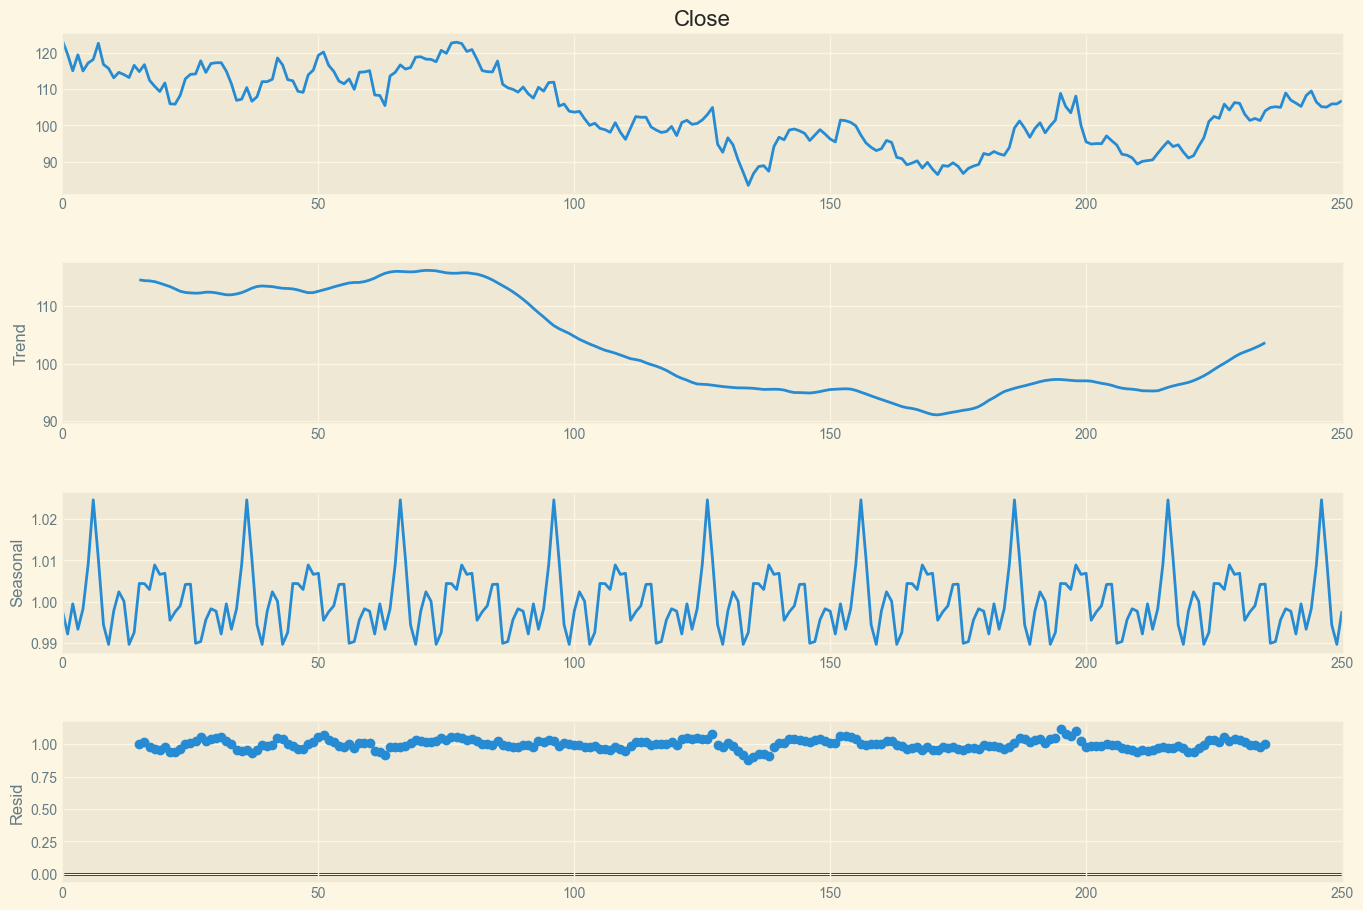

In [99]:
result = seasonal_decompose(data['Close'], 
                            model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

To determine if the time series is stationary or seasonal, we can examine the residual component of the decomposition. If the residual component appears to be random noise with a constant mean and variance, then the time series can be considered stationary. On the other hand, if the residual component exhibits a repeating pattern over time, then the time series may have a seasonal component.

So my data is not stationary it is seasonal, I need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data, but before using the SARIMA model, I will use the ARIMA model.

To use ARIMA or SARIMA, I need to find the p, d, and q values. I can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot, the value of d is either 0 or 1. If the data is stationary, I should use 0, and if the data is seasonal, I should use 1. As my data is seasonal, I should use 1 as the d value.

Now here’s how to find the value of p:

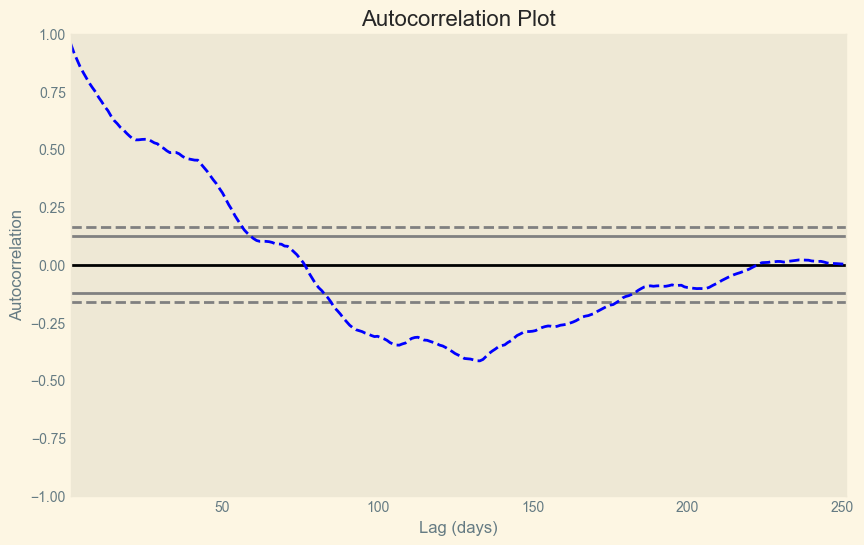

In [100]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(data['Close'], color='blue', linestyle='--')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



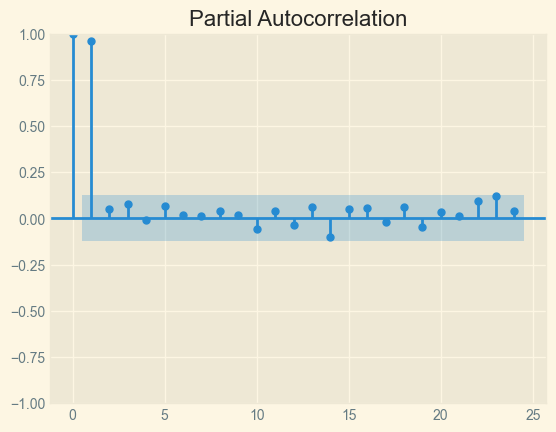

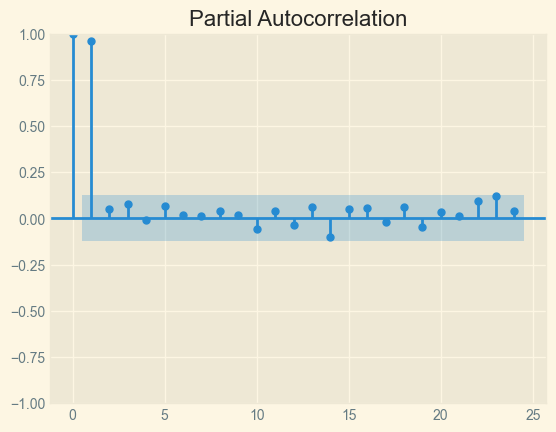

In [101]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['Close'])

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

In [102]:
p, d, q = 5, 1, 2
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Close'], order=(p,d,q))
fitted_model = model.fit()
display(fitted_model.summary())

c:\Users\maraujo\OneDrive\MachineLearningPortifolio\venv\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -590.808
Date:                Tue, 25 Apr 2023   AIC                           1197.616
Time:                        10:16:03   BIC                           1225.788
Sample:                             0   HQIC                          1208.954
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1166      0.135     -0.862      0.388      -0.382       0.148
ar.L2          0.8509      0.137      6.207      0.000       0.582       1.120
ar.L3         -0.0195      0.082     -0.237      0.813      -0.181       0.142
ar.L4          0.0054      0.073      0.073      0.941      -0.139       0.149
ar.L5          0.0108      0.065      0.166      0.868      -0.117       0.139
ma.L1          0.0706      0.318      0.222      0.824      -0.552       0.693
ma.L2         -0.9285      0.299     -3.107      0.002      -1.514      -0.343
sigma2         6.5928      1.806      3.651      0.000       3.053      10.132
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.06
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we predict the values using the ARIMA model

In [103]:
predictions = fitted_model.predict()
display(predictions)

0        0.000000
1      123.249971
2      119.636350
3      115.393815
4      119.674676
          ...    
246    106.078990
247    105.051623
248    104.910495
249    105.832445
250    105.707871
Name: predicted_mean, Length: 251, dtype: float64

The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [104]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -580.135
Date:                            Tue, 25 Apr 2023   AIC                           1190.271
Time:                                    10:16:18   BIC                           1242.355
Sample:                                         0   HQIC                          1211.261
                                            - 251                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0428      0.733     -0.058      0.953      -1.479       1.393
ar.L2          0.3475      0.655      0.531      0.595      -0.935       1.630
ar.L3         -0.0132      0.073     -0.182      0.856      -0.156       0.130
ar.L4         -0.0340      0.077     -0.443      0.658      -0.185       0.117
ar.L5         -0.0835      0.085     -0.981      0.327      -0.250       0.083
ma.L1         -0.0264      0.727     -0.036      0.971      -1.450       1.398
ma.L2         -0.4115      0.673     -0.612      0.541      -1.730       0.907
ar.S.L12      -0.2238      0.898     -0.249      0.803      -1.983       1.535
ar.S.L24      -0.1085      0.132     -0.825      0.409      -0.366       0.149
ar.S.L36      -0.0363      0.129     -0.282      0.778      -0.289       0.216
ar.S.L48      -0.0214      0.126     -0.170      0.865      -0.268       0.225
ar.S.L60      -0.1083      0.108     -0.999      0.318      -0.321       0.104
ma.S.L12      -0.7741      0.880     -0.880      0.379      -2.498       0.950
ma.S.L24      -0.0866      0.852     -0.102      0.919      -1.756       1.582
sigma2         6.9373      0.715      9.704      0.000       5.536       8.338
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.31
Prob(Q):                              0.92   Prob(JB):                         0.04
Heteroskedasticity (H):               0.67   Skew:                             0.17
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [105]:
predictions = model.predict(len(data), len(data)+10)
display(predictions)

251    107.224838
252    107.412342
253    106.262201
254    105.529398
255    105.031623
256    105.500217
257    105.872363
258    106.557336
259    106.852103
260    106.768319
261    106.183575
Name: predicted_mean, dtype: float64

Then, we plot the predictions:

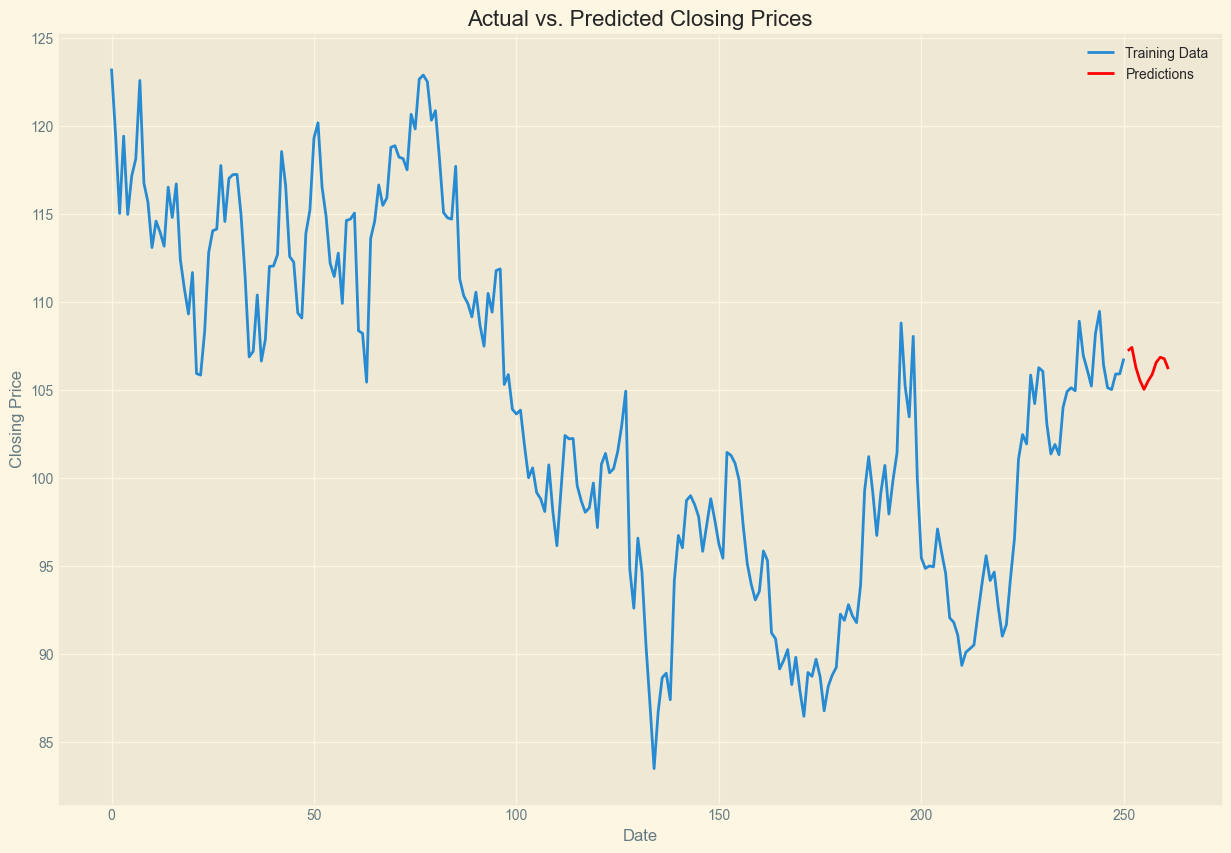

In [106]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data['Close'], label='Training Data')
ax.plot(predictions, label='Predictions', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title('Actual & Predicted Closing Prices')
ax.legend()